# Attention tokens

In [1]:
import torch
from transformer_lens import HookedTransformer, SVDInterpreter

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
import random
import numpy as np
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from rich import print
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from transformer_lens.utils import Slice
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
def decompose_head(cache, l, h, pos=None):
    start, end = 0, len(cache['q', l][0])
    if pos is not None:
        start, end = pos
    q = cache['q', l][:, start:end, h, :]
    k = cache['k', l][:, start:end, h, :]
    v = cache['v', l][:, start:end, h, :]
    return torch.stack([q, k, v])

def project_attn(cache, l, h, mlp=True, **kwargs):
    OV = cache.model.OV[l, h]
    mlp_in = model.W_in[l]
    mlp_out = model.W_out[l]

    cs = decompose_head(cache, l, h, **kwargs)
    proj_A = torch.einsum('c b i h, d h -> c b i d', cs, OV.A)
    proj_B = torch.einsum('c b i d, h d -> c b i d', proj_A, OV.B)
    out = proj_B
    if mlp:
        mlped = torch.einsum('c b i d, d j -> c b i j', proj_B, mlp_in)
        mlped_out = torch.einsum('c b i j, j d -> c b i d', mlped, mlp_out)
        out = mlped_out
    return out

def head2logits(cache, l, h, **kwargs):
    projections = project_attn(cache, l, h, **kwargs)
    logits = cache.model.unembed(projections)
    return logits

In [14]:
def head2preds(cache, hp, l, h, k=1):
    OV = cache.model.OV[l, h]
    proj_A = torch.einsum('b n m h, d h -> b n m d', hp, OV.A)
    proj_B = torch.einsum('b n m d, h d -> b n m d', proj_A, OV.B)
    out = proj_B
    logits = cache.model.unembed(out[0])
    preds = torch.topk(logits, k, dim=-1).indices
    return preds

def parse_tokens(tokens):
    for i in range(len(tokens)):
        for j in range(len(tokens[i])):
            t = tokens[i][j]
            if t == '\n':
                tokens[i][j] = '<nl>'
            if t == ' ':
                tokens[i][j] = '<sp>'
            if t == '\t':
                tokens[i][j] = '<tab>'
            if t == '<|endoftext|>':
                tokens[i][j] = 'EOS'
    return tokens

def head_component_to_tokens(cache, layer, head, component, **kwargs):
    preds = head2preds(cache, component, layer, head, **kwargs)
    str_preds = parse_tokens([
        cache.model.to_str_tokens(p) 
        for p in preds
    ])
    return str_preds

def calculate_attention_tokens(cache, layer, head, hp, **kwargs):
    str_preds = head_component_to_tokens(cache, layer, head, hp, **kwargs)

    # Create a unique list of tokens, maintaining the order they first appear
    unique_tokens = {}
    for i in range(0, len(str_preds)):
        for j in range(i + 1):
            token = str_preds[i][j]
            if token not in unique_tokens:
                unique_tokens[token] = len(unique_tokens)
    
    sequence_length = len(str_preds)
    
    token_matrix = torch.full((sequence_length, sequence_length), -1).to(device)
    for i in range(sequence_length):
        for j in range(i + 1):
            token = str_preds[i][j]
            token_matrix[i, j] = unique_tokens[token]

    return token_matrix, unique_tokens

def plot_attention_head(cache, layer, head, cmap=None, labels=True, **kwargs):
    patterns = cache['attn', layer][:, head, :, :]
    sequence_length = patterns.shape[-1]
    pattern = patterns.mean(dim=0)
    q, k, v = decompose_head(cache, layer, head)
    hp = q.unsqueeze(2) * k.unsqueeze(1)
    token_matrix, attention_tokens = calculate_attention_tokens(cache, layer, head, hp, **kwargs)
    attention_token_labels = list(attention_tokens.keys())
    q_str_preds = head_component_to_tokens(cache, layer, head, q.unsqueeze(1), **kwargs)
    k_str_preds = head_component_to_tokens(cache, layer, head, k.unsqueeze(1), **kwargs)
    v_str_preds = head_component_to_tokens(cache, layer, head, v.unsqueeze(1), **kwargs)

    fig = px.imshow(
        token_matrix.cpu(),
        color_continuous_scale=cmap,
        color_continuous_midpoint=0.0,
        title=f'Attention head {head} at layer {layer}',
    )

    input_tokens = parse_tokens(
        [cache.model.to_str_tokens(random.choice(cache.prompts))]
    )[0]

    min_opacity = 0.3
    for i in range(sequence_length):
        if labels:
            fig.add_annotation(x=-1, y=i, text=input_tokens[i], showarrow=False, xshift=-15, yshift=0, font=dict(size=16, color='black'))
            fig.add_annotation(x=sequence_length, y=i, text=v_str_preds[0][i], showarrow=False, xshift=15, yshift=0, font=dict(size=16, color='black'))
            fig.add_annotation(x=i, y=sequence_length, text=input_tokens[i], textangle=45, showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='black'))
            fig.add_annotation(x=i, y=-1, text=q_str_preds[0][i], textangle=-45, showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='black'))
        for j in range(i + 1):
            text = attention_token_labels[int(token_matrix[i, j].item())]
            opacity = max(min(pattern[i, j].item() + min_opacity, 1), min_opacity)
            if labels:
                fig.add_annotation(
                    x=j,
                    y=i,
                    text=text,
                    textangle=-45,
                    showarrow=False,
                    font=dict(color="white"),
                    opacity=opacity,
                )

            if pattern[i, j] > min_opacity:
                fig.add_shape(
                    type="rect",
                    x0=j-0.5,
                    y0=i-0.5,
                    x1=j+0.5,
                    y1=i+0.5,
                    line=dict(color="white", width=2),
                    fillcolor="rgba(0, 0, 0, 0)",
                )
    
    fig.update_coloraxes(showscale=False)
    fig.update_layout(
        width=1200, height=800,
        plot_bgcolor='white',
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False, autorange='reversed'),
    )

    return fig

In [5]:
def run_prompt(model, *prompts):
    print(f'Running prompt: {prompts}')
    _, cache = model.run_with_cache(list(prompts))
    cache.prompts = list(prompts)
    return cache

In [6]:
import plotly.graph_objects as go
from ipywidgets import Dropdown, Output, VBox, HBox
from IPython.display import display

def create_image_gallery(plots):
    dropdown = Dropdown(
        options=[(f'Plot {i+1}', i) for i in range(len(plots))],
        value=0,
        description='Select Plot:',
    )
    output = Output()

    def update_plot(change):
        with output:
            output.clear_output()
            plots[change['new']].show()

    dropdown.observe(update_plot, names='value')
    display(VBox([dropdown, output]))

    # Initialize with the first plot
    update_plot({'new': 0})

    return output

def compare_plots(*plots):
    outputs = [Output() for _ in plots]

    for out, plot in zip(outputs, plots):
        with out:
            plot.show()

    display(HBox(outputs))


In [7]:
from ipywidgets import HBox, Output, widgets
import plotly.graph_objects as go

def compare_plots(*plots, figure_layout={'width': 400, 'height': 300}):
    # Initialize an HBox widget to hold all plots side by side
    hbox = HBox(layout={'display': 'flex', 'flex_flow': 'row', 'align_items': 'stretch', 'width': '100%'})
    
    print(f'Plots: {len(plots)}')
    for plot in plots:
        # Create an output widget for each plot
        out = Output()
        with out:
            # Apply layout adjustments to the plot
            plot.update_layout(width=figure_layout['width'], height=figure_layout['height'])
        
        # Add the output widget to the HBox
        hbox.children += (out,)

    # Display the HBox with all plots
    display(hbox)


In [8]:
from ipywidgets import Dropdown, Output, VBox, Layout
from IPython.display import display, clear_output
import plotly.graph_objects as go

def create_image_gallery(plots):
    dropdown = Dropdown(
        options=[(f'Plot {i+1}', i) for i in range(len(plots))],
        value=0,
        description='Select Plot:',
    )
    output = Output()

    def update_plot(change):
        with output:
            clear_output(wait=True)  # Clear the previous plot
            # Directly display the selected plot
            plots[change['new']].show()

    dropdown.observe(update_plot, names='value')

    # Initialize with the first plot
    update_plot({'new': 0})

    return VBox([dropdown, output])


In [9]:
from ipywidgets import HBox, Output, Layout
from IPython.display import display
import plotly.graph_objects as go

def compare_plots(*plots, figure_layout={'width': 800, 'height': 500}):
    outputs = [Output() for _ in plots]

    for out, plot in zip(outputs, plots):
        # Apply layout adjustments to each plot
        plot.update_layout(width=figure_layout['width'], height=figure_layout['height'])
        with out:
            # Use IPython.display.display instead of plot.show()
            display(plot)

    # Set up a scrollable horizontal box layout
    scrollable_layout = Layout(display='flex', flex_flow='row', overflow='scroll hidden', 
                               border='solid 1px', align_items='stretch', width='auto', height=f"{figure_layout['height'] + 20}px")

    display(HBox(outputs, layout=scrollable_layout))


In [10]:
from ipywidgets import HBox, Layout
import plotly.graph_objects as go

def compare_plots(*plots, figure_layout={'width': 800, 'height': 500}):
    # Convert Plotly figures to FigureWidgets with the desired layout
    plot_widgets = [
        go.FigureWidget(p.update_layout(width=figure_layout['width'], height=figure_layout['height'])) for p in plots
    ]
    
    # Set up a horizontal box layout
    hbox_layout = Layout(display='flex', flex_flow='row', overflow='scroll hidden', 
                         border='solid 1px', align_items='stretch', width='100%', height=f"{figure_layout['height'] + 20}px")
    
    # Create an HBox with the plot widgets
    hbox = HBox(plot_widgets, layout=hbox_layout)
    
    # Display the HBox directly
    display(hbox)

In [11]:
from ipywidgets import HBox, Layout
import plotly.graph_objects as go
from ipywidgets import Dropdown, VBox, Output
from IPython.display import display, clear_output
from ipywidgets import HBox, Layout
import plotly.graph_objects as go
from IPython.display import display

def compare_plots(*plots, figure_layout={'width': '800', 'height': '500'}):
    widgets = []
    
    for plot in plots:
        # Check if the plot is a Figure and convert it to FigureWidget for interactivity
        if isinstance(plot, go.Figure):
            plot = go.FigureWidget(plot)
        plot.layout.width = figure_layout['width']
        plot.layout.height = figure_layout['height']
        widgets.append(plot)

    # Create an HBox with the plot widgets
    hbox = HBox(widgets, layout=Layout(display='flex', flex_flow='row', align_items='stretch'))
    display(hbox)

def create_image_gallery(plots):
    dropdown = Dropdown(options=[(f'Plot {i+1}', i) for i in range(len(plots))], description='Select Plot:')
    output = Output()
    current_index = 0
    
    def update_plot(change):
        nonlocal current_index
        # Check if the function is being called post-initialization
        with output:
            clear_output(wait=True)
            current_index = change['new']
            plots[change['new']].show()

    dropdown.observe(update_plot, names='value')

    gallery = VBox([dropdown, output])
    return gallery

Running prompt: ('The next sentence is a lie. The previous sentence is true.',)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


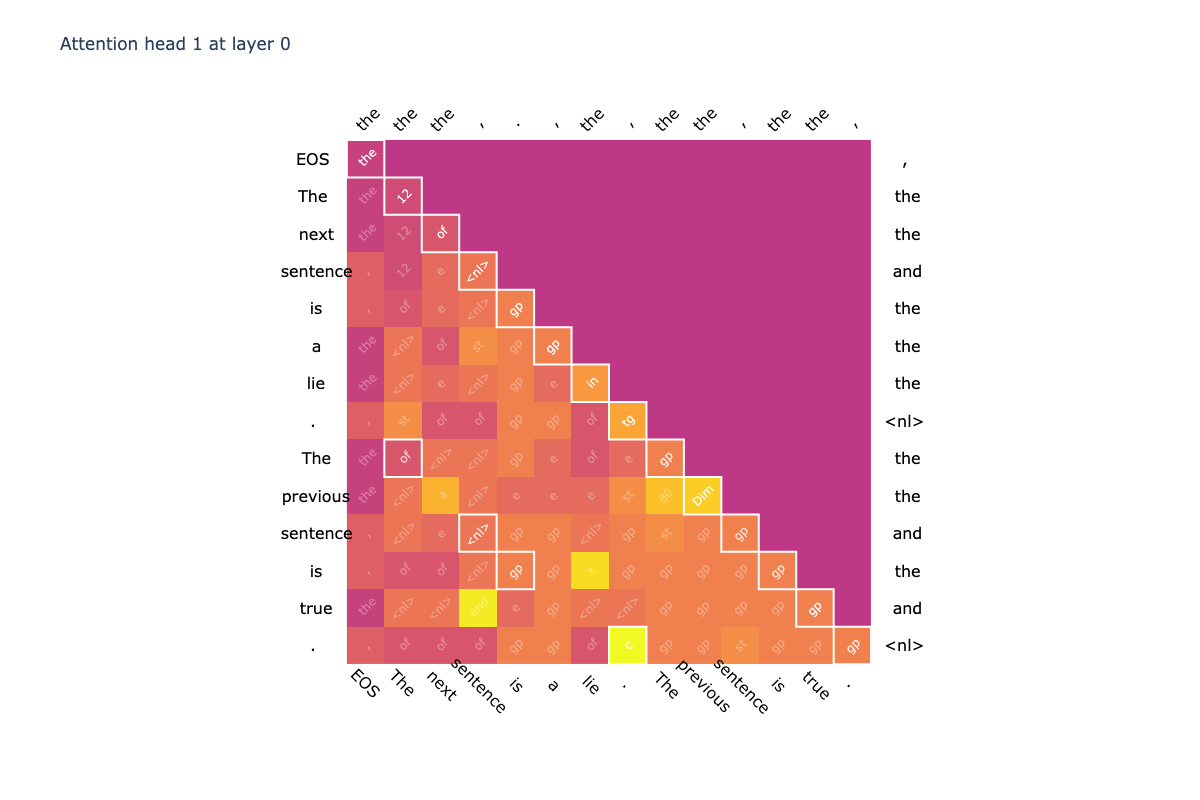

In [12]:
cache = run_prompt(model, "The next sentence is a lie. The previous sentence is true.")
fig = plot_attention_head(cache, 0, 1)
fig.show()

In [13]:
compare_plots(fig, fig)

ValueError: 
    Invalid value of type 'builtins.str' received for the 'width' property of layout
        Received value: '800'

    The 'width' property is a number and may be specified as:
      - An int or float in the interval [10, inf]

## Random token sequences

In [ ]:
prompt = "John went to the river, to the bank, and to the beach."
cache = run_prompt(model, prompt)

Running prompt: ('John went to the river, to the bank, and to the beach.',)

In [ ]:
plots = []
for i in range(0, 12):
    for j in range(11, 12):
        plots.append(
            plot_attention_head(cache, i, j)
        )

len(plots)

12

In [ ]:
create_image_gallery(plots)


In [ ]:
prompt = "Tim was born in 19"
cache = run_prompt(model, prompt)

for i in range(0, 12):
    for j in range(0, 12):
        fig = plot_attention_head(cache, i, j, cmap='Viridis', labels=False)
        fig.show()

In [ ]:
base_pattern = torch.randint(0, 50257, (1, 1), device=device)
prompt = base_pattern.repeat(1, 32)
cache = run_prompt(model, model.to_string(prompt[0]))

for i in range(0, 12):
    for j in range(0, 12):
        fig = plot_attention_head(cache, i, j, cmap='Viridis', labels=False)
        fig.show()

In [ ]:
base_pattern = torch.randint(0, 50257, (1, 4), device=device)
prompt = base_pattern.repeat(1, 8)
cache = run_prompt(model, model.to_string(prompt[0]))

for i in range(0, 12):
    for j in range(0, 12):
        fig = plot_attention_head(cache, i, j, cmap='Viridis', labels=False)
        fig.show()

In [ ]:
base_pattern = torch.randint(0, 50257, (1, 4), device=device)
mirrored_pattern = torch.cat((base_pattern, torch.flip(base_pattern, dims=[1])), dim=1)
prompt = mirrored_pattern.repeat(1, 4)
cache = run_prompt(model, model.to_string(prompt[0]))

plot = make_subplots(rows=1, cols=2, subplot_titles=("Layer 0", "Layer 11"))
for i in range(0, 12):
    fig = plot_attention_head(cache, 0, i, cmap='Viridis', labels=False)
    fig.show()

In [ ]:
base_pattern_1 = torch.randint(0, 50257, (1, 4), device=device)
base_pattern_2 = torch.randint(0, 50257, (1, 4), device=device)
prompt = torch.cat((base_pattern_1, base_pattern_2) * 4, dim=1)
cache = run_prompt(model, model.to_string(prompt[0]))

for l in range(0, 12):
    fig = plot_attention_head(cache, 0, l, cmap='Viridis', labels=False)
    fig.show()

In [ ]:
haikus = [
    "Amid lines of code, Patterns dance in torch's glow, Insight blooms, shared flow.",
    "Digital quest shared, Silent tensors weave and merge, Clarity unfurls.",
    "In code's embrace, thoughts Spin, seeking truth in patterns, Discovery's path.",
]

prompt = ' '.join(haikus)
cache = run_prompt(model, prompt)

for l in range(0, 12):
    for h in range(0, 12):
        fig = plot_attention_head(cache, l, h, cmap='Viridis', labels=False)
        fig.show()

In [ ]:
prompt = "Universality is a key hypothesis in mechanistic interpretability – that different models learn similar features and circuits when trained on similar task." 
cache = run_prompt(model, prompt)

for l in range(0, 12):
    for h in range(0, 12):
        fig = plot_attention_head(cache, l, h, cmap='Viridis', labels=False)
        fig.show()

open questions
---

- are head tokens consistent across inputs?
- do head token counts remain consistent across inputs?
  - plot graphs for this
- which tokens are shared across all heads if any?
- are shared tokens common across inputs?
- how many tokens are used per row?

improvements
---
- plot Q in the top diagonal
- add border to cells over an attention score threshold
- plot resid stream predictions
- plot K instead of Q*K
  - if useful, add diagonal for Q*K at current token
- plot averaged inputs instead of individual prompts
- plot grid of attention token graphs
  - needs to run head calculations in parellel
- craft prompt for gpt to analyse patterns in attention tokens